# Level 6: Image Generation
**Platform:** [Forus Octagon](https://octagon-students.ru/about)  
**Competency:** Generative Models  
**Student:** Mikhail Kuzmin  

## Preparation for Main Project
This competency develops skills in generative models that will be applied in the main project **"Diagram Recognition"** for:
- Synthetic training data generation
- Advanced image transformation techniques
- Exploring conditional generation for diagram components

## License Information
- **This notebook's code:** [MIT License](https://github.com/mikhail-ku/Forus-Octagon-CV/blob/ed8c2f3e84bb1e160a05087333af549afbf0993b/LICENSE)
- **External resources:** [models_licenses.md](../../../../models_licenses.md)

---

#Задание первое

Используйте [статью из документации HuggingFace](https://huggingface.co/microsoft/dit-base) для генерации изображений. Выведите на экран 4 примера сгенерированных изображений (по 2 для двух классов).

In [ ]:
!git clone https://github.com/facebookresearch/DiT.git
import DiT, os
os.chdir('DiT')
os.environ['PYTHONPATH'] = '/env/python:/content/DiT'
!pip install diffusers timm --upgrade
# DiT imports:
import torch
from torchvision.utils import save_image
from diffusion import create_diffusion
from diffusers.models import AutoencoderKL
from download import find_model
from models import DiT_XL_2
from PIL import Image
from IPython.display import display
torch.set_grad_enabled(False)
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cpu":
    print("GPU not found. Using CPU instead.")


fatal: destination path 'DiT' already exists and is not an empty directory.
GPU not found. Using CPU instead.


In [ ]:
image_size = 256 #@param [256, 512]
vae_model = "stabilityai/sd-vae-ft-ema" #@param ["stabilityai/sd-vae-ft-mse", "stabilityai/sd-vae-ft-ema"]
latent_size = int(image_size) // 8
# Load model:
model = DiT_XL_2(input_size=latent_size).to(device)
state_dict = find_model(f"DiT-XL-2-{image_size}x{image_size}.pt")
model.load_state_dict(state_dict)
model.eval() # important!
vae = AutoencoderKL.from_pretrained(vae_model).to(device)

100%|██████████| 2.70G/2.70G [00:14<00:00, 192MB/s]
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

  0%|          | 0/50 [00:00<?, ?it/s]

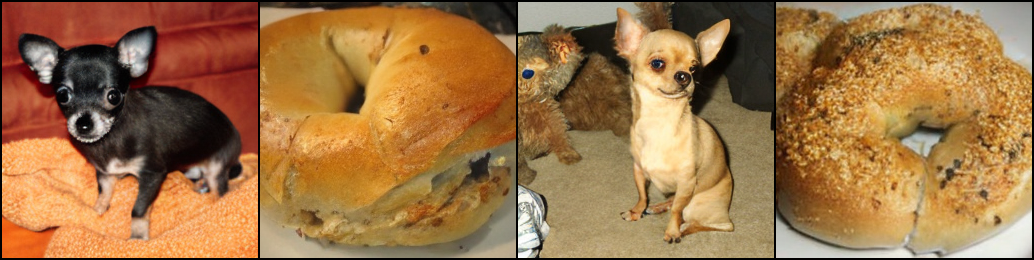

In [ ]:
# Set user inputs:
seed = 0 #@param {type:"number"}
torch.manual_seed(seed)
num_sampling_steps = 50 #@param {type:"slider", min:0, max:1000, step:1}
cfg_scale = 5 #@param {type:"slider", min:1, max:10, step:0.1}
class_labels = 151, 931, 151, 931 #@param {type:"raw"}
samples_per_row = 4 #@param {type:"number"}

# Create diffusion object:
diffusion = create_diffusion(str(num_sampling_steps))

# Create sampling noise:
n = len(class_labels)
z = torch.randn(n, 4, latent_size, latent_size, device=device)
y = torch.tensor(class_labels, device=device)

# Setup classifier-free guidance:
z = torch.cat([z, z], 0)
y_null = torch.tensor([1000] * n, device=device)
y = torch.cat([y, y_null], 0)
model_kwargs = dict(y=y, cfg_scale=cfg_scale)

# Sample images:
samples = diffusion.p_sample_loop(
    model.forward_with_cfg, z.shape, z, clip_denoised=False,
    model_kwargs=model_kwargs, progress=True, device=device
)
samples, _ = samples.chunk(2, dim=0)  # Remove null class samples
samples = vae.decode(samples / 0.18215).sample

# Save and display images:
save_image(samples, "sample.png", nrow=int(samples_per_row),
           normalize=True, value_range=(-1, 1))
samples = Image.open("sample.png")
display(samples)

In [ ]:
vae.save_pretrained("/content/drive/MyDrive/my_models")

In [ ]:
output_path = "/content/drive/MyDrive/my_models/DiT_XL_2.pt"
torch.save(model.state_dict(), output_path)

#Задание второе

Дообучите эту модель для своего класса.

Скачайте набор данных по ссылке: [кликабельно](https://www.kaggle.com/datasets/samuelcortinhas/muffin-vs-chihuahua-image-classification)

Дообучите модель по генерации изображений по двум классам: чихуахуа и маффины.

Сгенерируйте 6 различных изображений (по 3 картинки для двух классов).